*Single Task & Multi-Task based Architectures Implementation*

**Dataset Used**
- https://www.kaggle.com/datasets/sunandabiswas24/brain-mri-image-dataset

- https://www.kaggle.com/datasets/briscdataset/brisc2025

- MyDrive: https://drive.google.com/drive/folders/1nz1wAAG-jqV-WtcXkoZaS0A7l4A2o6pX?usp=drive_link



EDA

### DATASET 1 : 🧠EPIC & CSCR Dataset : Epic Healthcare LTD, সেন্টার ফর স্পেসালাইজড কেয়ার এবং রিসার্চ (সিএসসিআর)
- Annotated Dataset for Brain Tumor Image Segmentation and Classification

- https://www.kaggle.com/datasets/sunandabiswas24/brain-mri-image-dataset

In [1]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### ✅Import & Install dependencies

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
!pip install tensorflow

In [4]:

# To install Keras
!pip install -q tensorflow keras keras-cv

In [5]:
!pip install -U matplotlib==3.8.4 seaborn==0.13.2
#!pip install --force-reinstall --no-deps matplotlib==3.9.4

In [6]:
!pip install --user torchcam
!pip install --user torch
!pip install --user torch torchvision torchaudio

In [7]:
!pip install tensorflow_datasets

In [8]:
import tensorflow as tf
import keras_cv
import pandas as pd
import numpy as np
import zipfile
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.models import MobileNet_V2_Weights, DenseNet201_Weights
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torchvision import models

In [9]:
from google.colab import drive
import zipfile, os

In [10]:
import matplotlib as mpl, matplotlib.cm as cm
if not hasattr(cm, "register_cmap"):
    cm.register_cmap = mpl.colormaps.register  # compatibility shim

In [11]:
# Compatibility shim that accepts both (name, cmap) and (cmap, name=...)
def _compat_register_cmap(*args, **kwargs):
    # Old style: register_cmap(name, cmap)
    if len(args) >= 2 and isinstance(args[1], mpl.colors.Colormap):
        name, cmap = args[0], args[1]
    # New style: register(cmap, name=...)
    elif len(args) >= 1 and isinstance(args[0], mpl.colors.Colormap):
        cmap = args[0]
        name = kwargs.pop('name', getattr(cmap, 'name', None))
    else:
        # Keyword-only usage
        name = kwargs.get('name')
        cmap = kwargs.get('cmap')
    return mpl.colormaps.register(cmap=cmap, name=name, **{k:v for k,v in kwargs.items() if k != 'cmap'})

# Install the shim only if needed
if not hasattr(cm, "register_cmap") or cm.register_cmap is not _compat_register_cmap:
    cm.register_cmap = _compat_register_cmap

# Now import seaborn safely
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

In [12]:
%matplotlib inline
import matplotlib as mpl, seaborn as sns
print("Matplotlib:", mpl.__version__)
print("Seaborn:", sns.__version__)

import sys, platform
print("Python:", sys.version)
print("OS:", platform.platform())

import torch, torchvision, PIL, matplotlib, seaborn, numpy, pandas
print("torch:", torch.__version__, "| cuda available:", torch.cuda.is_available())
print("torchvision:", torchvision.__version__)
print("Pillow:", PIL.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", seaborn.__version__)
print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("TensorFlow version:", tf.__version__)
print("KerasCV version:", keras_cv.__version__)

Matplotlib: 3.8.4
Seaborn: 0.13.2
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
OS: Linux-6.1.123+-x86_64-with-glibc2.35
torch: 2.8.0+cu126 | cuda available: True
torchvision: 0.23.0+cu126
Pillow: 11.3.0
matplotlib: 3.8.4
seaborn: 0.13.2
numpy: 1.26.4
pandas: 2.2.2
TensorFlow version: 2.19.0
KerasCV version: 0.9.0


#### Upload and Unzip Dataset


In [13]:
# 📁 Path to your ZIP inside Google Drive
# Example: if your file is in MyDrive/CSCR hospital Dataset.zip
zip_path = "/content/drive/MyDrive/Dataset/CSCR hospital Dataset.zip"

# 📂 Where to extract
extract_dir = "/content/Brain_Tumor_Dataset"

# ✅ Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Files extracted to: {extract_dir}")


✅ Files extracted to: /content/Brain_Tumor_Dataset


#### 🔍 Checking Folder Structure


In [14]:
# ✅ Optional: print directory structure to verify
for root, dirs, files in os.walk(extract_dir):
    print(root, "->", len(files), "files")

/content/Brain_Tumor_Dataset -> 0 files
/content/Brain_Tumor_Dataset/Epic and CSCR hospital Dataset -> 0 files
/content/Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Train -> 0 files
/content/Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Train/glioma -> 3018 files
/content/Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Train/meningioma -> 2183 files
/content/Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Train/notumor -> 1945 files
/content/Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Train/pituitary -> 2504 files
/content/Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Test -> 0 files
/content/Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Test/glioma -> 755 files
/content/Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Test/meningioma -> 546 files
/content/Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Test/notumor -> 487 files
/content/Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Test/pituitary -> 626 files


##### 🗂 4. Load Images and Labels ==>Preprocess dataset (images + labels)


In [15]:
image_paths = []
image_labels = []

# ✅ Correct root folder
data_root = os.path.join("Brain_Tumor_Dataset", "Epic and CSCR hospital Dataset")

# ✅ Use correct folder names: Train and Test
for split in ["Train", "Test"]:
    split_path = os.path.join(data_root, split)
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if os.path.isdir(label_path):
            for fname in os.listdir(label_path):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(label_path, fname))
                    image_labels.append(label)

# ✅ Summary
classes = sorted(set(image_labels))
print("Classes:", classes)
print("Total samples:", len(image_paths))


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total samples: 12064


In [16]:

# ✅ Root dataset path
data_root = os.path.join("Brain_Tumor_Dataset", "Epic and CSCR hospital Dataset")

image_paths = []
image_labels = []

# ✅ Traverse both Train and Test splits
for split in ["Train", "Test"]:
    split_path = os.path.join(data_root, split)
    if not os.path.exists(split_path):
        continue
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if os.path.isdir(label_path):
            for fname in os.listdir(label_path):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(label_path, fname))
                    image_labels.append(label)

# ✅ Make DataFrame
df = pd.DataFrame({"image_path": image_paths, "label": image_labels})

# ✅ Summary
classes = sorted(df["label"].unique())
print("Classes:", classes)
print("Total samples:", len(df))
print(df.head())


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total samples: 12064
                                          image_path   label
0  Brain_Tumor_Dataset/Epic and CSCR hospital Dat...  glioma
1  Brain_Tumor_Dataset/Epic and CSCR hospital Dat...  glioma
2  Brain_Tumor_Dataset/Epic and CSCR hospital Dat...  glioma
3  Brain_Tumor_Dataset/Epic and CSCR hospital Dat...  glioma
4  Brain_Tumor_Dataset/Epic and CSCR hospital Dat...  glioma


In [17]:
df

,image_path,label
0,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,glioma
1,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,glioma
2,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,glioma
3,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,glioma
4,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,glioma
...,...,...
12059,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,pituitary
12060,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,pituitary
12061,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,pituitary
12062,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,pituitary


In [18]:
df.shape

(12064, 2)

In [19]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [20]:
df.duplicated().sum()

0

In [21]:
df.isnull().sum()

,0
image_path,0
label,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12064 entries, 0 to 12063
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  12064 non-null  object
 1   label       12064 non-null  object
dtypes: object(2)
memory usage: 188.6+ KB


In [23]:
df['label'].unique()

array(['glioma', 'meningioma', 'notumor', 'pituitary'], dtype=object)

In [24]:
df['label'].value_counts()

,count
label,
glioma,3773
pituitary,3130
meningioma,2729
notumor,2432


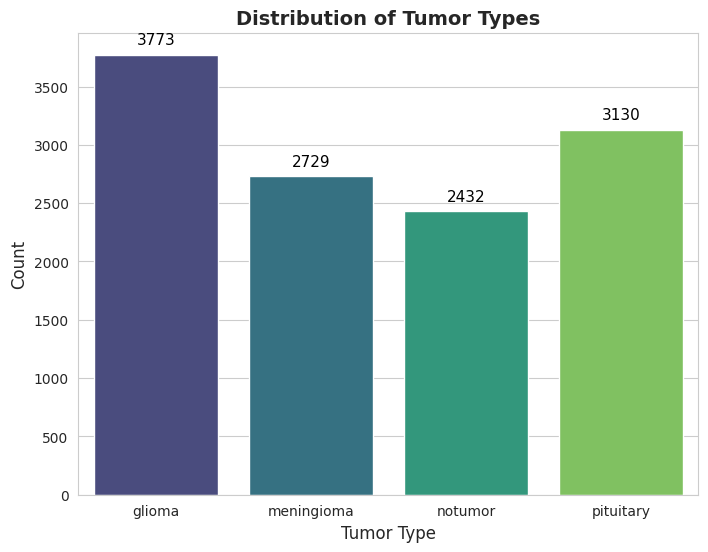

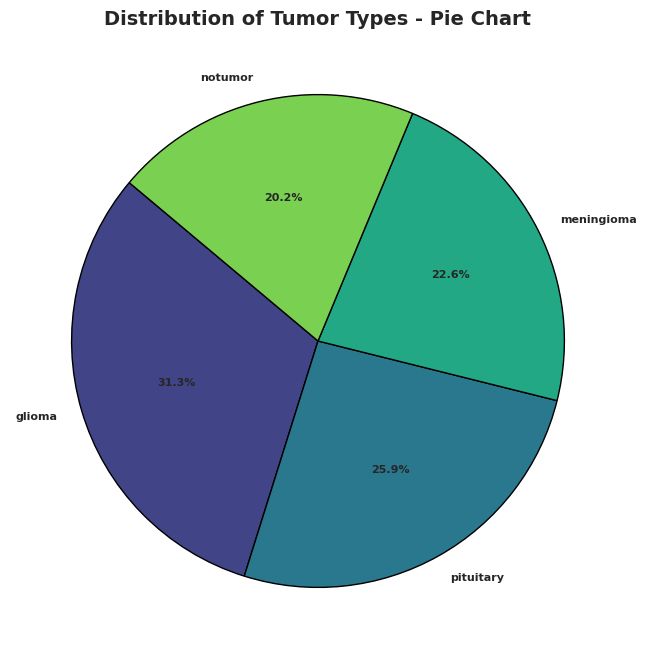

In [25]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)

ax.set_title("Distribution of Tumor Types", fontsize=14, fontweight='bold')
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.show()

label_counts = df["label"].value_counts()

fig, ax = plt.subplots(figsize=(10, 8))
colors = sns.color_palette("viridis", len(label_counts))

ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
       startangle=140, colors=colors, textprops={'fontsize': 8, 'weight': 'bold'},
       wedgeprops={'edgecolor': 'black', 'linewidth': 1})

ax.set_title("Distribution of Tumor Types - Pie Chart", fontsize=14, fontweight='bold')

plt.show()

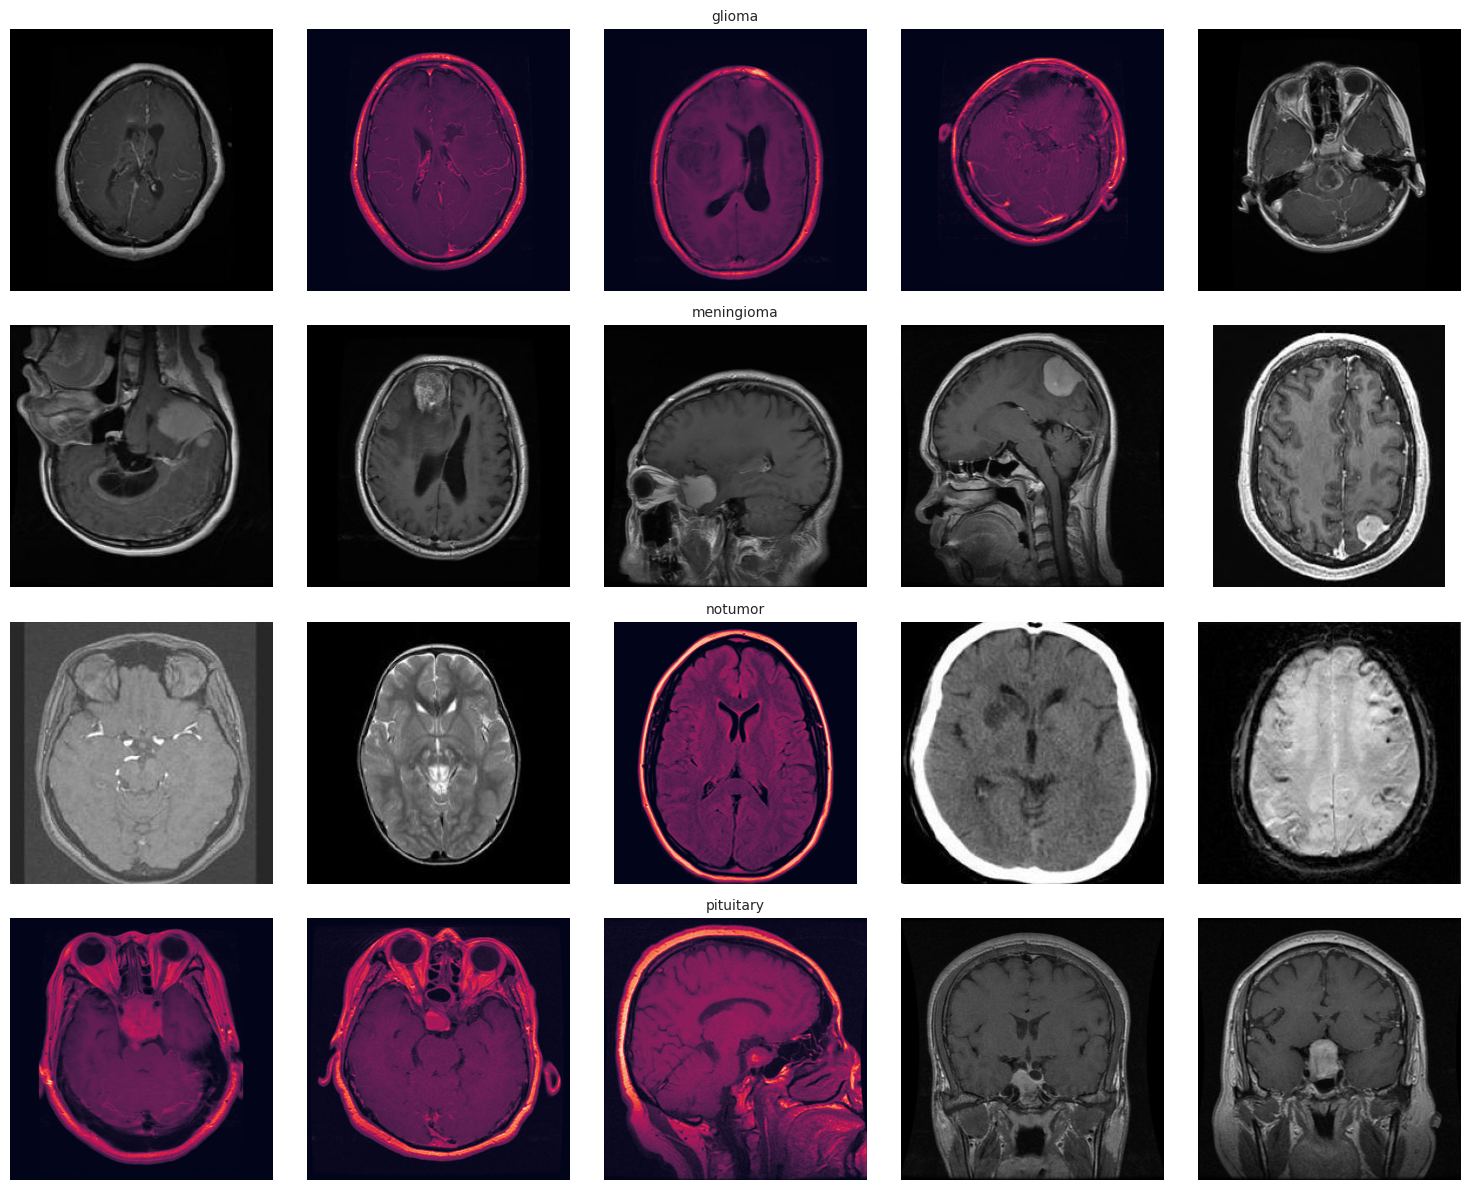

In [26]:
num_images = 5

unique_labels = df['label'].unique()

plt.figure(figsize=(15, len(unique_labels) * 3))

for row_idx, label in enumerate(unique_labels):

    label_images = df[df['label'] == label].head(num_images)['image_path'].tolist()

    for col_idx, img_path in enumerate(label_images):
        plt_idx = row_idx * num_images + col_idx + 1
        plt.subplot(len(unique_labels), num_images, plt_idx)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        if col_idx == 2:
            plt.title(label, fontsize=10)

plt.tight_layout()
plt.show()

In [27]:
max_samples = df['label'].value_counts().max()

balanced_df = df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=max_samples, replace=True, random_state=42)
).reset_index(drop=True)

balanced_df = balanced_df[['image_path', 'label']]

In [28]:
df1_balanced = balanced_df
df1_balanced

,image_path,label
0,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,glioma
1,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,glioma
2,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,glioma
3,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,glioma
4,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,glioma
...,...,...
15087,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,pituitary
15088,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,pituitary
15089,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,pituitary
15090,Brain_Tumor_Dataset/Epic and CSCR hospital Dat...,pituitary


### DATASET 2 : 🧠 BRISC 2025
- Annotated Dataset for Brain Tumor Image Segmentation and Classification

- https://www.kaggle.com/datasets/briscdataset/brisc2025

In [29]:
from google.colab import drive
import zipfile, os


# 📁 Path to your ZIP inside Google Drive
# Example: if your file is in MyDrive/CSCR hospital Dataset.zip
zip_path = "/content/drive/MyDrive/Dataset/BRISC2025.zip"

# 📂 Where to extract
extract_dir = "/content/Brain_Tumor_Dataset_2"

# ✅ Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Files extracted to: {extract_dir}")

✅ Files extracted to: /content/Brain_Tumor_Dataset_2


In [30]:
# ✅ Optional: print directory structure to verify
for root, dirs, files in os.walk(extract_dir):
    print(root, "->", len(files), "files")

/content/Brain_Tumor_Dataset_2 -> 0 files
/content/Brain_Tumor_Dataset_2/brisc2025 -> 0 files
/content/Brain_Tumor_Dataset_2/brisc2025/classification_task -> 0 files
/content/Brain_Tumor_Dataset_2/brisc2025/classification_task/train -> 0 files
/content/Brain_Tumor_Dataset_2/brisc2025/classification_task/train/glioma -> 1147 files
/content/Brain_Tumor_Dataset_2/brisc2025/classification_task/train/meningioma -> 1329 files
/content/Brain_Tumor_Dataset_2/brisc2025/classification_task/train/pituitary -> 1457 files
/content/Brain_Tumor_Dataset_2/brisc2025/classification_task/train/no_tumor -> 1067 files
/content/Brain_Tumor_Dataset_2/brisc2025/classification_task/test -> 0 files
/content/Brain_Tumor_Dataset_2/brisc2025/classification_task/test/glioma -> 254 files
/content/Brain_Tumor_Dataset_2/brisc2025/classification_task/test/meningioma -> 306 files
/content/Brain_Tumor_Dataset_2/brisc2025/classification_task/test/pituitary -> 300 files
/content/Brain_Tumor_Dataset_2/brisc2025/classificati

In [31]:
import os

# ✅ Correct root path (raw string)
root_path = r"/content/Brain_Tumor_Dataset_2/brisc2025/classification_task/train"

image_paths = []
labels = []

for label in os.listdir(root_path):
    label_path = os.path.join(root_path, label)
    if os.path.isdir(label_path):
        for fname in os.listdir(label_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(label_path, fname))
                labels.append(label)

print("Total images:", len(image_paths))
print("Classes:", sorted(set(labels)))

Total images: 5000
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


In [32]:
import os, pandas as pd

# ✅ Point directly to the BRISC classification task folder
data_root = "/content/Brain_Tumor_Dataset_2/brisc2025/classification_task"

image_paths, image_labels, splits = [], [], []

for split in ["train", "test"]:
    split_path = os.path.join(data_root, split)
    if not os.path.exists(split_path):
        print(f"⚠️ Missing: {split_path}")
        continue

    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if not os.path.isdir(label_path):
            continue

        for fname in os.listdir(label_path):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(label_path, fname))
                image_labels.append(label)
                splits.append(split)

# ✅ Build the DataFrame (THIS was missing)
df = pd.DataFrame({"image_path": image_paths, "label": image_labels, "split": splits})

# Optional: normalize labels (merge notumor → no_tumor)
df["label"] = df["label"].str.strip().str.lower().replace({"notumor": "no_tumor"})

print("Classes:", sorted(df["label"].unique()))
print("Total samples:", len(df))
print(df.head())


Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Total samples: 6000
                                          image_path   label  split
0  /content/Brain_Tumor_Dataset_2/brisc2025/class...  glioma  train
1  /content/Brain_Tumor_Dataset_2/brisc2025/class...  glioma  train
2  /content/Brain_Tumor_Dataset_2/brisc2025/class...  glioma  train
3  /content/Brain_Tumor_Dataset_2/brisc2025/class...  glioma  train
4  /content/Brain_Tumor_Dataset_2/brisc2025/class...  glioma  train


In [33]:
df

,image_path,label,split
0,/content/Brain_Tumor_Dataset_2/brisc2025/class...,glioma,train
1,/content/Brain_Tumor_Dataset_2/brisc2025/class...,glioma,train
2,/content/Brain_Tumor_Dataset_2/brisc2025/class...,glioma,train
3,/content/Brain_Tumor_Dataset_2/brisc2025/class...,glioma,train
4,/content/Brain_Tumor_Dataset_2/brisc2025/class...,glioma,train
...,...,...,...
5995,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test
5996,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test
5997,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test
5998,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test


In [34]:
df.shape

(6000, 3)

In [35]:
df.columns

Index(['image_path', 'label', 'split'], dtype='object')

In [36]:
df.duplicated().sum()

0

In [37]:
df.isnull().sum()

,0
image_path,0
label,0
split,0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  6000 non-null   object
 1   label       6000 non-null   object
 2   split       6000 non-null   object
dtypes: object(3)
memory usage: 140.8+ KB


In [39]:
df['label'].unique()

array(['glioma', 'meningioma', 'pituitary', 'no_tumor'], dtype=object)

In [40]:
df['label'].value_counts()

,count
label,
pituitary,1757
meningioma,1635
glioma,1401
no_tumor,1207


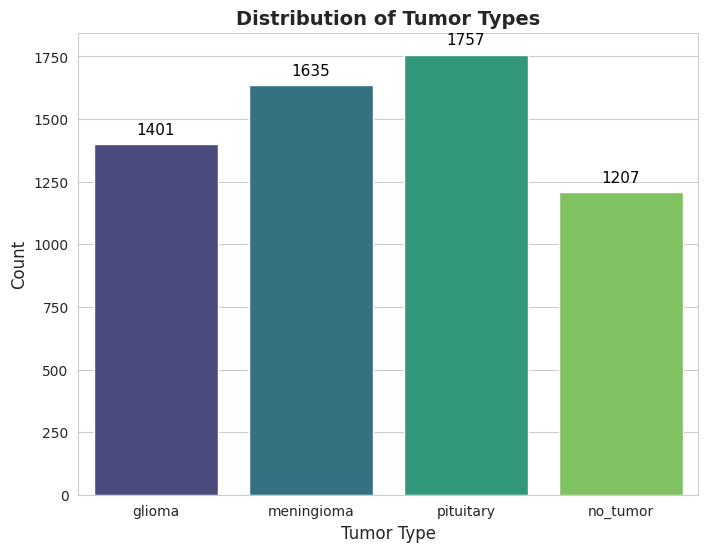

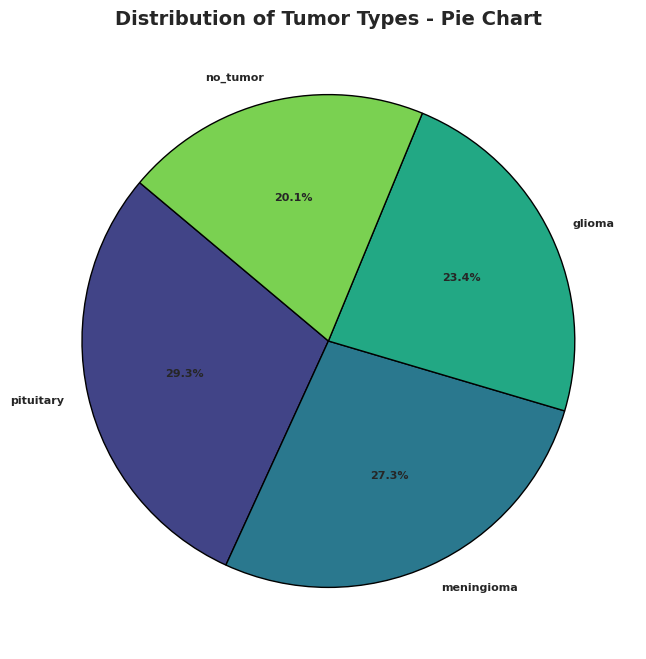

In [41]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)

ax.set_title("Distribution of Tumor Types", fontsize=14, fontweight='bold')
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.show()

label_counts = df["label"].value_counts()

fig, ax = plt.subplots(figsize=(10, 8))
colors = sns.color_palette("viridis", len(label_counts))

ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
       startangle=140, colors=colors, textprops={'fontsize': 8, 'weight': 'bold'},
       wedgeprops={'edgecolor': 'black', 'linewidth': 1})

ax.set_title("Distribution of Tumor Types - Pie Chart", fontsize=14, fontweight='bold')

plt.show()

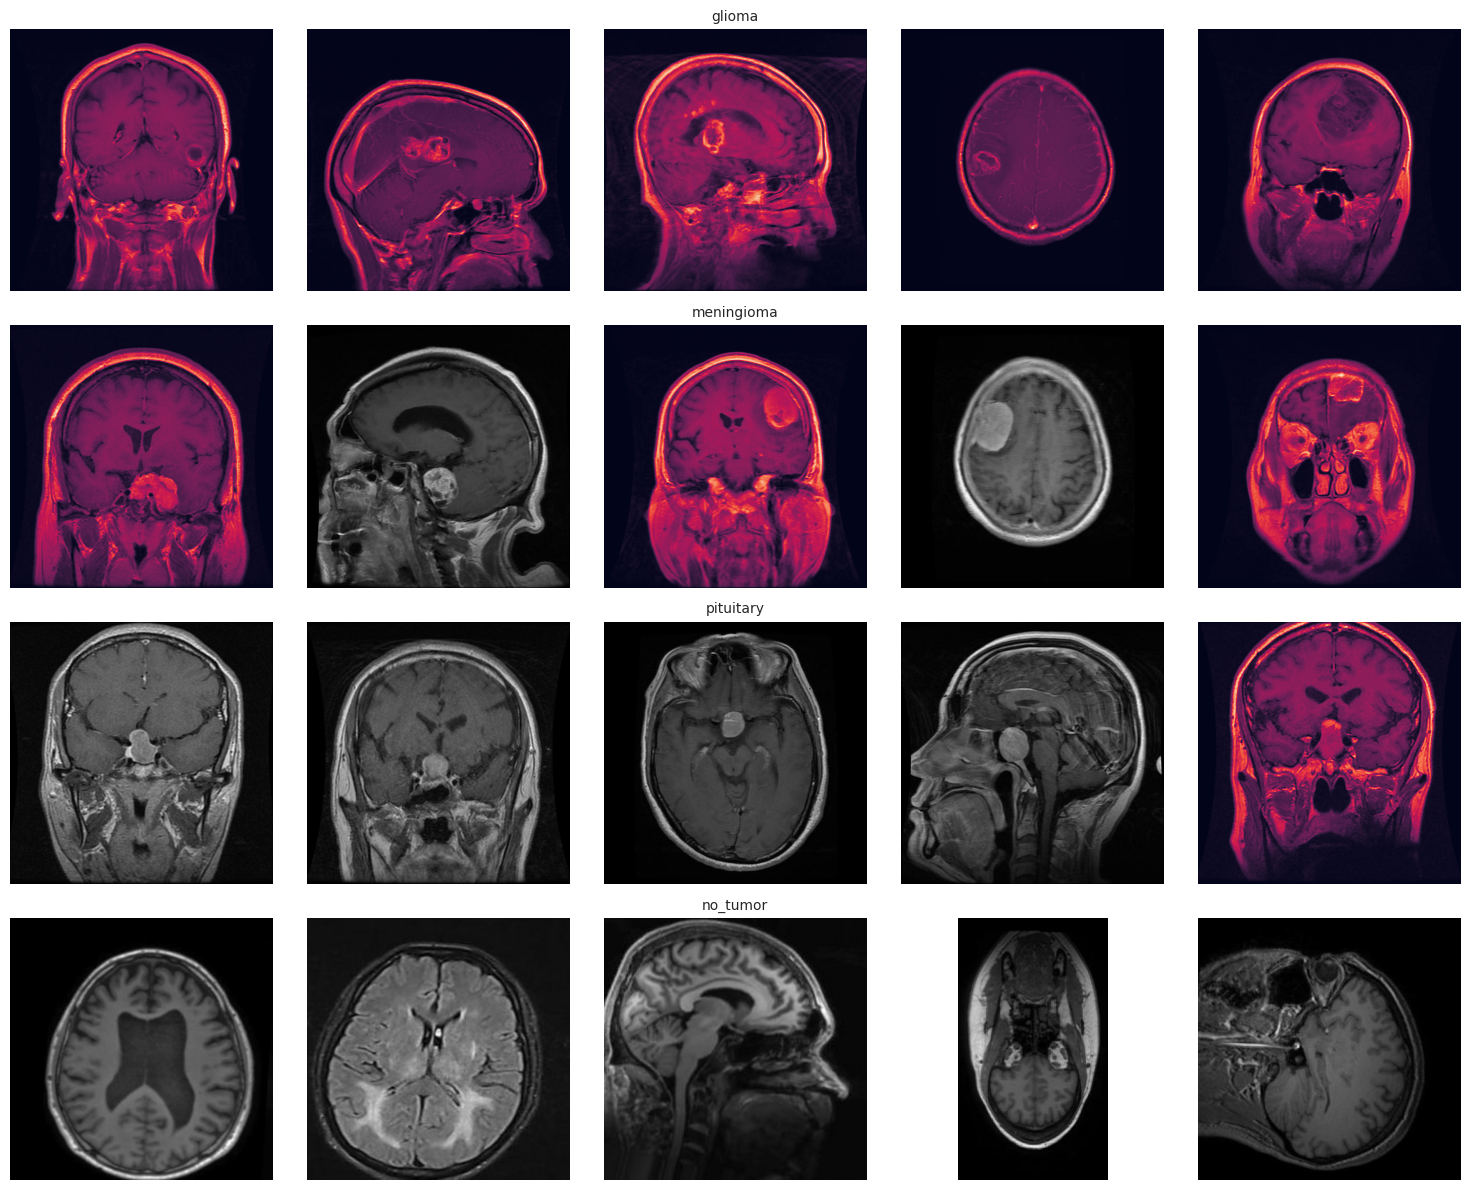

In [42]:
num_images = 5

unique_labels = df['label'].unique()

plt.figure(figsize=(15, len(unique_labels) * 3))

for row_idx, label in enumerate(unique_labels):

    label_images = df[df['label'] == label].head(num_images)['image_path'].tolist()

    for col_idx, img_path in enumerate(label_images):
        plt_idx = row_idx * num_images + col_idx + 1
        plt.subplot(len(unique_labels), num_images, plt_idx)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        if col_idx == 2:
            plt.title(label, fontsize=10)

plt.tight_layout()
plt.show()

### *Merging Two Dataset together category wise to make the dataset large*

In [43]:
def collect_dataset(root, splits=("train", "test")):
    records = []
    for split in splits:
        split_path = os.path.join(root, split)
        if not os.path.exists(split_path):
            continue
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if os.path.isdir(label_path):
                for fname in os.listdir(label_path):
                    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                        records.append({
                            "image_path": os.path.join(label_path, fname),
                            "label": label,
                            "split": split  # Add the split information here
                        })
    return pd.DataFrame(records)

# ✅ Dataset A (CSCR/Epic)
cscr_root = r"/content/Brain_Tumor_Dataset/Epic and CSCR hospital Dataset"
df_cscr = collect_dataset(cscr_root, splits=("Train", "Test"))
df_cscr["split"] = df_cscr["split"].str.lower()  # normalize

# ✅ Dataset B (BRISC2025)
brisc_root = "/content/Brain_Tumor_Dataset_2/brisc2025/classification_task" # Use the correct path
df_brisc = collect_dataset(brisc_root, splits=("train", "test"))

# ✅ Merge both
df_all = pd.concat([df_cscr, df_brisc], ignore_index=True)

print("CSCR shape:", df_cscr.shape)
print("BRISC shape:", df_brisc.shape)
print("Combined shape:", df_all.shape)
print("\nClasses:", df_all["label"].unique())
print(df_all.head())

CSCR shape: (12064, 3)
BRISC shape: (6000, 3)
Combined shape: (18064, 3)

Classes: ['glioma' 'meningioma' 'notumor' 'pituitary' 'no_tumor']
                                          image_path   label  split
0  /content/Brain_Tumor_Dataset/Epic and CSCR hos...  glioma  train
1  /content/Brain_Tumor_Dataset/Epic and CSCR hos...  glioma  train
2  /content/Brain_Tumor_Dataset/Epic and CSCR hos...  glioma  train
3  /content/Brain_Tumor_Dataset/Epic and CSCR hos...  glioma  train
4  /content/Brain_Tumor_Dataset/Epic and CSCR hos...  glioma  train


In [44]:
df_all

,image_path,label,split
0,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
1,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
2,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
3,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
4,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
...,...,...,...
18059,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test
18060,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test
18061,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test
18062,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test


In [45]:
df_all.describe

<bound method NDFrame.describe of                                               image_path     label  split
0      /content/Brain_Tumor_Dataset/Epic and CSCR hos...    glioma  train
1      /content/Brain_Tumor_Dataset/Epic and CSCR hos...    glioma  train
2      /content/Brain_Tumor_Dataset/Epic and CSCR hos...    glioma  train
3      /content/Brain_Tumor_Dataset/Epic and CSCR hos...    glioma  train
4      /content/Brain_Tumor_Dataset/Epic and CSCR hos...    glioma  train
...                                                  ...       ...    ...
18059  /content/Brain_Tumor_Dataset_2/brisc2025/class...  no_tumor   test
18060  /content/Brain_Tumor_Dataset_2/brisc2025/class...  no_tumor   test
18061  /content/Brain_Tumor_Dataset_2/brisc2025/class...  no_tumor   test
18062  /content/Brain_Tumor_Dataset_2/brisc2025/class...  no_tumor   test
18063  /content/Brain_Tumor_Dataset_2/brisc2025/class...  no_tumor   test

[18064 rows x 3 columns]>

In [46]:
# Replace both 'notumor' and 'no_tumor' with unified 'no_tumor'
df_all['label'] = df_all['label'].replace({'notumor': 'no_tumor'})

# Check unique labels again
print("Unique classes after merge:", df_all['label'].unique())
print("Class counts:\n", df_all['label'].value_counts())

Unique classes after merge: ['glioma' 'meningioma' 'no_tumor' 'pituitary']
Class counts:
 label
glioma        5174
pituitary     4887
meningioma    4364
no_tumor      3639
Name: count, dtype: int64


In [47]:
df_all.shape

(18064, 3)

In [48]:
df_all

,image_path,label,split
0,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
1,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
2,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
3,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
4,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
...,...,...,...
18059,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test
18060,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test
18061,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test
18062,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test


In [49]:
train_df = df_all[df_all["split"]=="train"]
test_df  = df_all[df_all["split"]=="test"]

In [50]:
train_df

,image_path,label,split
0,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
1,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
2,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
3,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
4,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
...,...,...,...
17059,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,train
17060,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,train
17061,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,train
17062,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,train


In [51]:
test_df

,image_path,label,split
9650,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,test
9651,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,test
9652,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,test
9653,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,test
9654,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,test
...,...,...,...
18059,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test
18060,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test
18061,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test
18062,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,test


In [52]:
train_df.shape

(14650, 3)

In [53]:
train_df.columns

Index(['image_path', 'label', 'split'], dtype='object')

In [54]:
train_df.duplicated().sum()

0

In [55]:
train_df.isnull().sum()

,0
image_path,0
label,0
split,0


In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14650 entries, 0 to 17063
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  14650 non-null  object
 1   label       14650 non-null  object
 2   split       14650 non-null  object
dtypes: object(3)
memory usage: 457.8+ KB


In [57]:
train_df['label'].unique()

array(['glioma', 'meningioma', 'no_tumor', 'pituitary'], dtype=object)

In [58]:
train_df

,image_path,label,split
0,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
1,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
2,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
3,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
4,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
...,...,...,...
17059,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,train
17060,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,train
17061,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,train
17062,/content/Brain_Tumor_Dataset_2/brisc2025/class...,no_tumor,train


*random oversampling to equalize class counts—a standard imbalance-fixing step.*

In [59]:
# Merge labels if needed first, e.g. df['label'].replace({'notumor':'no_tumor'}, inplace=True)

train_df = df_all[df_all['split']=='train'].copy()
val_df   = df_all[df_all['split']=='test'].copy()  # or your separate test/val

max_n = train_df['label'].value_counts().max()
train_bal = (
    train_df.groupby('label', group_keys=False)
    .apply(lambda x: x.sample(n=max_n, replace=True, random_state=42))
    .reset_index(drop=True)
)

print(train_bal['label'].value_counts())  # should be equal across classes


label
glioma        4165
meningioma    4165
no_tumor      4165
pituitary     4165
Name: count, dtype: int64


In [60]:
train_df =train_bal

In [61]:
train_df

,image_path,label,split
0,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
1,/content/Brain_Tumor_Dataset_2/brisc2025/class...,glioma,train
2,/content/Brain_Tumor_Dataset_2/brisc2025/class...,glioma,train
3,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,glioma,train
4,/content/Brain_Tumor_Dataset_2/brisc2025/class...,glioma,train
...,...,...,...
16655,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,pituitary,train
16656,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,pituitary,train
16657,/content/Brain_Tumor_Dataset_2/brisc2025/class...,pituitary,train
16658,/content/Brain_Tumor_Dataset/Epic and CSCR hos...,pituitary,train


In [62]:
train_df = train_df[['image_path', 'label']]

In [63]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16660 entries, 0 to 16659
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  16660 non-null  object
 1   label       16660 non-null  object
dtypes: object(2)
memory usage: 260.4+ KB


In [64]:
print("Class counts:\n", train_df['label'].value_counts())

Class counts:
 label
glioma        4165
meningioma    4165
no_tumor      4165
pituitary     4165
Name: count, dtype: int64


# Model Implementation: Model names and their applications, the official paperworks related to this....

https://arxiv.org/abs/2506.14318

# MobileDenseAttn Model Application: https://arxiv.org/pdf/2508.18294

# MobileDenseNet: A new approach to object detection on mobile devices_https://www.researchgate.net/publication/362229689_MobileDenseNet_A_new_approach_to_object_detection_on_mobile_devices

# https://github.com/aidlearning/AidLearning-FrameWork/tree/master/src/facencnn/models

# https://github.com/tensorflow/models/blob/master/official/vision/modeling/backbones/mobiledet.py

*Model Result Calculation*

*RESTNET50 - Model Results*

Epoch 01: train loss 0.5572, acc 0.9000 | val loss 0.4671, acc 0.9517
Epoch 02: train loss 0.4231, acc 0.9706 | val loss 0.4609, acc 0.9467
Epoch 03: train loss 0.3899, acc 0.9865 | val loss 0.3886, acc 0.9883
Epoch 04: train loss 0.3788, acc 0.9896 | val loss 0.4551, acc 0.9483
Epoch 05: train loss 0.3794, acc 0.9890 | val loss 0.4196, acc 0.9767
Epoch 06: train loss 0.3686, acc 0.9931 | val loss 0.3743, acc 0.9917
Epoch 07: train loss 0.3590, acc 0.9981 | val loss 0.3700, acc 0.9917
Epoch 08: train loss 0.3568, acc 0.9983 | val loss 0.3705, acc 0.9917
Epoch 09: train loss 0.3557, acc 0.9985 | val loss 0.3734, acc 0.9900
Epoch 10: train loss 0.3541, acc 0.9994 | val loss 0.3695, acc 0.9917


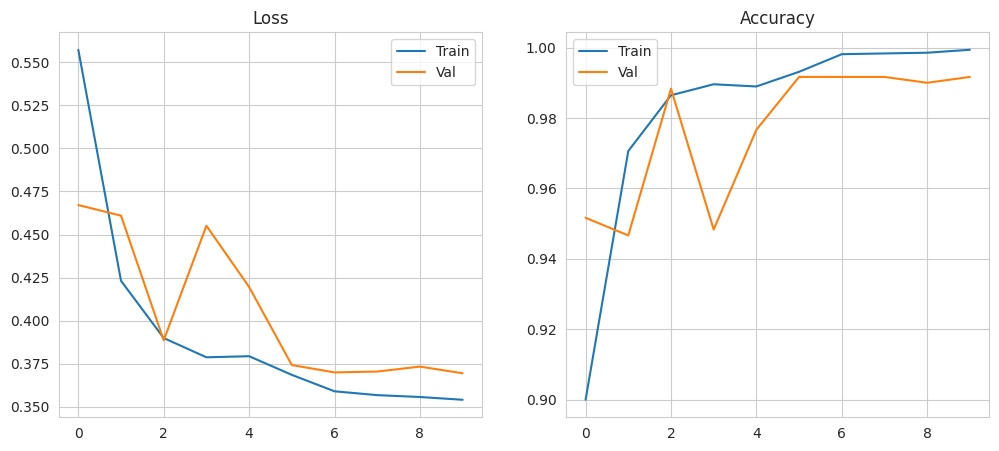

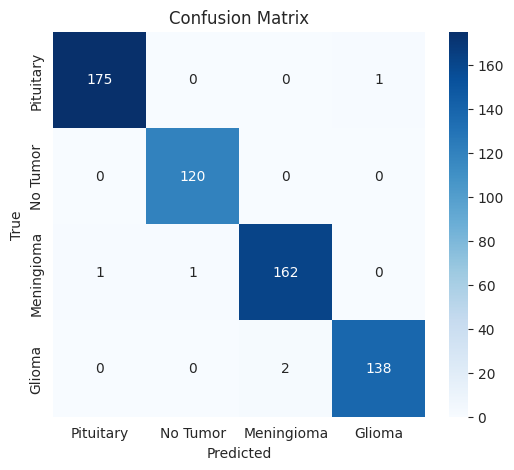

Classification Report:

              precision    recall  f1-score   support

   Pituitary       0.99      0.99      0.99       176
    No Tumor       0.99      1.00      1.00       120
  Meningioma       0.99      0.99      0.99       164
      Glioma       0.99      0.99      0.99       140

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



In [77]:
# ===============================
# Brain Tumor Classification with ResNet50
# ===============================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from copy import deepcopy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ===============================
# 1. Dataset
# ===============================

class BrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.label_map = {'pituitary': 0, 'no_tumor': 1, 'meningioma': 2, 'glioma': 3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'image_path']
        label = self.label_map[self.dataframe.loc[idx, 'label']]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


# ===============================
# 2. Data transforms
# ===============================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ===============================
# 3. Train/val/test split
# (assumes df already has columns: 'image_path', 'label')
# ===============================
df_train, df_test = train_test_split(df, test_size=0.2,
                                     stratify=df['label'], random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5,
                                   stratify=df_test['label'], random_state=42)

train_ds = BrainTumorDataset(df_train, transform=transform_train)
val_ds   = BrainTumorDataset(df_val,   transform=transform_eval)
test_ds  = BrainTumorDataset(df_test,  transform=transform_eval)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=32, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# ===============================
# 4. Build ResNet50
# ===============================
def build_resnet50(num_classes=4, dropout_p=0.3):
    try:
        weights = models.ResNet50_Weights.IMAGENET1K_V2
        net = models.resnet50(weights=weights)
    except Exception:
        net = models.resnet50(pretrained=True)
    in_feat = net.fc.in_features
    net.fc = nn.Sequential(
        nn.Dropout(p=dropout_p),
        nn.Linear(in_feat, num_classes)
    )
    return net

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_resnet50().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# ===============================
# 5. Training loop
# ===============================
from copy import deepcopy

EPOCHS = 10
best_model = deepcopy(model)
best_acc = 0

train_loss, train_acc = [], []
val_loss, val_acc = [], []

for i in range(1, EPOCHS+1):
    # ---- training ----
    model.train()
    running_loss, running_correct, total = 0, 0, 0
    for data, target in train_dl:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_correct += (out.argmax(1) == target).sum().item()
        total += target.size(0)
    train_loss.append(running_loss/len(train_dl))
    train_acc.append(running_correct/total)

    # ---- validation ----
    model.eval()
    val_running_loss, val_running_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for data, target in val_dl:
            data, target = data.to(device), target.to(device)
            out = model(data)
            loss = criterion(out, target)
            val_running_loss += loss.item()
            val_running_correct += (out.argmax(1) == target).sum().item()
            val_total += target.size(0)
    val_loss.append(val_running_loss/len(val_dl))
    val_acc.append(val_running_correct/val_total)

    # save best model
    if val_acc[-1] >= best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    scheduler.step()

    print(f"Epoch {i:02d}: "
          f"train loss {train_loss[-1]:.4f}, acc {train_acc[-1]:.4f} | "
          f"val loss {val_loss[-1]:.4f}, acc {val_acc[-1]:.4f}")

# ===============================
# 6. Plot curves
# ===============================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(train_loss, label="Train")
axes[0].plot(val_loss, label="Val")
axes[0].set_title("Loss")
axes[0].legend()

axes[1].plot(train_acc, label="Train")
axes[1].plot(val_acc, label="Val")
axes[1].set_title("Accuracy")
axes[1].legend()
plt.show()

# ===============================
# 7. Evaluate on test set
# ===============================
best_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for data, target in test_dl:
        data, target = data.to(device), target.to(device)
        out = best_model(data)
        preds = out.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Pituitary','No Tumor','Meningioma','Glioma'],
            yticklabels=['Pituitary','No Tumor','Meningioma','Glioma'],
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(all_labels, all_preds,
                            target_names=['Pituitary','No Tumor','Meningioma','Glioma']))
